In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
#path to the subsampled graph
path = 'out.gexf'

In [3]:
G = nx.read_gexf(path)

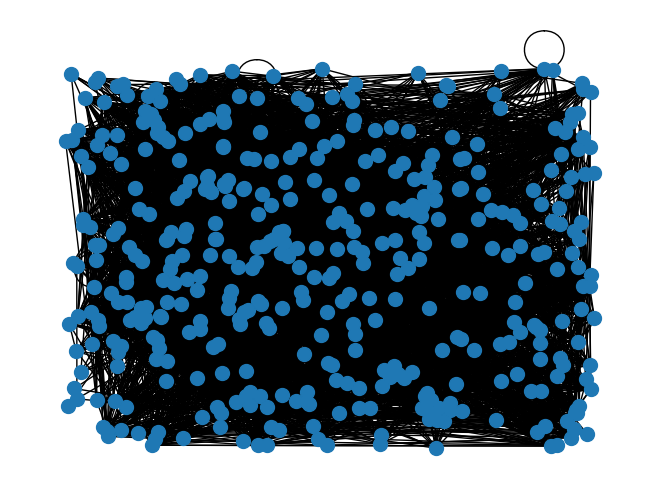

In [4]:
nx.draw(G,pos=nx.random_layout(G), with_labels=False, node_size=100)
plt.draw()

In [5]:
G.number_of_nodes()

419

In [6]:
#process data 

In [7]:
#fill_missing_val is a method used to complete data for missing days of the specified page

#load data
data_path = '/mnt/scratch/lts2/aspert/wikipedia/pageviews/pv-final-filt.parquet'
df = pd.read_parquet(data_path)  
all_dates = df['date']
start_date = all_dates.min().date()
end_date = all_dates.max().date()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')



In [8]:
all_titles = df['title'].values


In [9]:
#remove from Graph G nodes that do not exist in the data we have
#print counter to see progress
nodes_to_remove = []
i = 0
for n in G.nodes():
    i+=1
    tmp = n.replace(" ", "_")
    if tmp not in all_titles:
        print(i)
        nodes_to_remove.append(n)

1
2
4
8
24
25
30
33
44
46
51
58
69
76
83
84
85
86
87
88
93
107
114
117
120
121
122
124
143
144
145
149
150
152
165
170
171
173
175
176
183
190
193
194
221
222
224
225
226
229
230
232
234
235
236
239
240
243
246
251
254
258
259
262
263
264
265
266
267
268
269
270
271
272
273
278
279
280
289
292
295
298
300
307
310
311
314
315
317
318
321
324
340
344
345
348
351
353
362
370
372
373
374
377
381
385
389
399
406
415
416
418


In [10]:
print('initial nb of nodes  ', G.number_of_nodes())
G.remove_nodes_from(nodes_to_remove)
print('new nb of nodes  ', G.number_of_nodes())

initial nb of nodes   419
new nb of nodes   307


In [11]:
#save the new graph
#nx.write_gexf(G, "newG.gexf")

In [12]:
G = nx.read_gexf("newG.gexf")

In [13]:
example_page = df[df['title'] == 'Albert_Einstein'].sort_values('date')
example_page.count()

title         121
date          121
id            121
daily_sum     121
hourly_sum    121
dtype: int64

In [14]:
def fill_missing_data(node_title):
    """
    add missing dates for the given page, with
    default title: the title of the page
    default id: the id of the page
    default daily_sum: mean of the 'daily_sum' values for that page
    
    
    @param node_title: title of the given page
    
    """

    example_page = df[df['title'] == node_title].sort_values('date')
  
    new_indexed_example_page = example_page.set_index('date')
    new_example_page = new_indexed_example_page.reindex(index=date_range)
    new_example_page = new_example_page.drop(columns = ['hourly_sum'])
 
    default_title = new_example_page[new_example_page['title'].notnull()]['title'][0]
    default_id = new_example_page[new_example_page['id'].notnull()]['id'][0]
    default_daily_sum = new_example_page[new_example_page['title'] == node_title]['daily_sum'].mean()                #default_daily_sum = mean
    
    new_example_page['title'].fillna(default_title, inplace=True)
    new_example_page['id'].fillna(default_id, inplace=True)
    new_example_page['daily_sum'].fillna(default_daily_sum, inplace=True)
  
    columns_to_convert = ['id', 'daily_sum']
    new_example_page[columns_to_convert] = new_example_page[columns_to_convert].astype(int)
    
    return new_example_page

In [15]:
#add missing values for all pages
#print counter to see progress

counter = 0
frames = []

for n in G.nodes():
    counter+=1
    print(counter)
    tmp = n.replace(" ", "_")
    p = fill_missing_data(tmp)
    frames.append(p)

res = pd.concat(frames)
res.head(2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,title,id,daily_sum
2023-03-01,Ukraine,31750,19923
2023-03-02,Ukraine,31750,19409


In [16]:
processed_file_path = 'dataNotNormalized.csv' 
res.to_csv(processed_file_path)
data_processed = pd.read_csv('dataNotNormalized.csv' )
data_processed.head()

,Unnamed: 0,title,id,daily_sum
0,2023-03-01,Ukraine,31750,19923
1,2023-03-02,Ukraine,31750,19409
2,2023-03-03,Ukraine,31750,18545
3,2023-03-04,Ukraine,31750,18860
4,2023-03-05,Ukraine,31750,18727


In [17]:
# for the normalized data

In [18]:
import random
ids = res['id'].tolist()
chosen_id = random.choice(ids)

In [19]:
example_page = res[res['id'] == chosen_id]
example_page.tail(40)

,title,id,daily_sum
2023-05-22,Thermodynamics,29952,1099
2023-05-23,Thermodynamics,29952,1215
2023-05-24,Thermodynamics,29952,1201
2023-05-25,Thermodynamics,29952,1124
2023-05-26,Thermodynamics,29952,1045
2023-05-27,Thermodynamics,29952,920
2023-05-28,Thermodynamics,29952,1363
2023-05-29,Thermodynamics,29952,1415
2023-05-30,Thermodynamics,29952,1158
2023-05-31,Thermodynamics,29952,1092


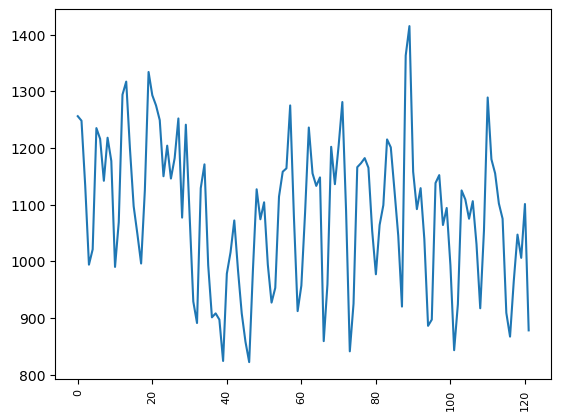

In [20]:

y = example_page['daily_sum']
plt.plot(y.to_numpy())
plt.tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()

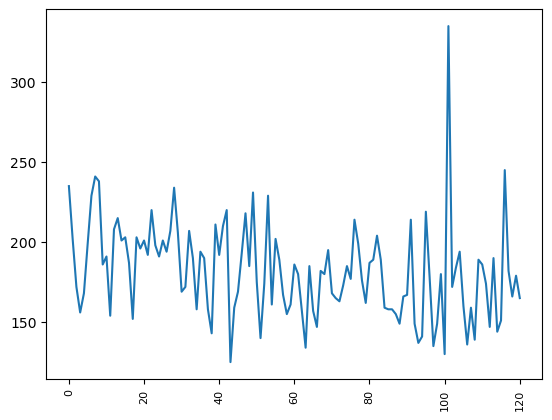

title         121
date          121
id            121
daily_sum     121
hourly_sum    121
dtype: int64

In [21]:
old_page = df[df['title'] == 'Philosophy_of_history'].sort_values('date')
y = old_page['daily_sum']
plt.plot(y.to_numpy())
plt.tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
old_page[old_page['daily_sum'] > 300]
old_page.count()

In [22]:
res.count()

title        37454
id           37454
daily_sum    37454
dtype: int64

In [23]:
#normalize data
res['Normalized_daily_sum'] = (res['daily_sum'] - res['daily_sum'].min()) / (res['daily_sum'].max() - res['daily_sum'].min())
res.head()

,title,id,daily_sum,Normalized_daily_sum
2023-03-01,Ukraine,31750,19923,0.324722
2023-03-02,Ukraine,31750,19409,0.316302
2023-03-03,Ukraine,31750,18545,0.302149
2023-03-04,Ukraine,31750,18860,0.307309
2023-03-05,Ukraine,31750,18727,0.305131


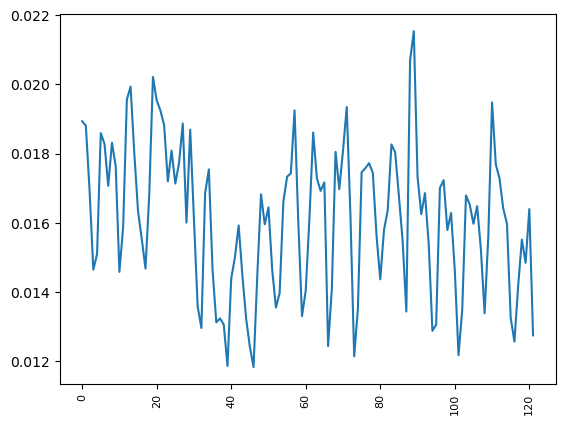

In [24]:
example_page = res[res['id'] == chosen_id]
y = example_page['Normalized_daily_sum']
plt.plot(y.to_numpy())
plt.tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()

In [25]:
res.count()


title                   37454
id                      37454
daily_sum               37454
Normalized_daily_sum    37454
dtype: int64

In [26]:
#save normalized data
processed_file_path = 'data.csv' 
res.to_csv(processed_file_path)

In [27]:
data_processed = pd.read_csv('data.csv' )
data_processed.head()

,Unnamed: 0,title,id,daily_sum,Normalized_daily_sum
0,2023-03-01,Ukraine,31750,19923,0.324722
1,2023-03-02,Ukraine,31750,19409,0.316302
2,2023-03-03,Ukraine,31750,18545,0.302149
3,2023-03-04,Ukraine,31750,18860,0.307309
4,2023-03-05,Ukraine,31750,18727,0.305131
